# steps

1. import water body 
1. get bounds
1. format bounds to string
1. use requests to download geojson for area
1. calculate overlap 
1. add data to shapes


In [66]:
def download_persil_data(shape, geoserver_url, basename, data_store_location, max_features = 100000):

    # get bounding box of water areas for request percil data
    xmin, ymin, xmax, ymax = shape.bounds 

    # request percil data
    url = geoserver_url + 'ows?service=WFS&version=1.0.0&request=GetFeature&typeName=petabpn:PersilBerdasarkanJenisHak&maxFeatures={}&outputFormat=application%2Fjson&BBOX={},{},{},{}'.format(
            max_features, xmin, ymin, xmax, ymax)

    local = data_store_location + basename + '.geojson'

    download_file(url, local)
    
    return local

def calculate_overlap(gdf_water, gdf_persil, overlap_types_init):
    # calculate total area of water 
    gdf_water['area'] = [geom.area for geom in gdf_water.geometry]

    # list to save overlap calculations
    overlap_dict_list = []


    for index, row in gdf_water.iterrows():

        # set overlap to zero again 
        overlap_types = overlap_types_init.copy()

        area = row['area']
        geometry_water = row['geometry']

        for index, row in gdf_persil.iterrows():

            geometry_persil = row['geometry']
            TIPEHAK = row['TIPEHAK']

            if geometry_persil.intersects(geometry_water):

                overlap = geometry_persil.intersection(geometry_water).area
                overlap_frac = (overlap/area) * 100 # calculate overlap in percent
                overlap_types[TIPEHAK] = overlap_types[TIPEHAK] + overlap_frac
        
        

        # round numbers to 2 decimals
        for name in overlap_types:
            overlap_types[name] = round(overlap_types[name],2)

        # save results
        overlap_dict_list.append(overlap_types)
        
    # pprint(overlap_dict_list)
    # add results to final gdf
    gdf_water['overlap'] = overlap_dict_list
    
    return gdf_water


In [67]:
# import helper functions 

# add helper function location
import sys 
sys.path.append('../../functions')

from helpers import *

In [68]:
import overpass
import shapely
import fiona
import glob

from shapely.ops import cascaded_union, unary_union
from shapely.geometry import shape, Point

import geopandas as gpd
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
from pprint import pprint

from tqdm.notebook import tqdm

In [69]:
# parameters 
water_files_location = '../../data/nir_green_blue/vectors/'

persil_data_store_location = '../../data/nir_green_blue/persil_overlap/'

geoserver_url = 'https://geosvc.atrbpn.go.id/geoserver/petabpn/'

In [70]:
# create download directory if it does not exist
make_dir(water_files_location)
make_dir(persil_data_store_location)    

Directory  ../../data/nir_green_blue/vectors/  already exists...
Directory  ../../data/nir_green_blue/persil_overlap/  already exists...


In [71]:
water_file_list = glob.glob(water_files_location + '*.geojson')

len(water_file_list)

446

In [ ]:


for water_file_path in tqdm(water_file_list):

    basename = os.path.basename(water_file_path).split('.')[0]

    # convert esri shapefiles to shapely objects
    # check valid geometries
    water_valid_shape_list, crs_check = check_valid_geometries(water_file_path)

    # convert list to shapely MultiPolgyons (in wgs84)
    water_wgs_shp = unary_union([shape(pol['geometry']) for pol in water_valid_shape_list])

    gdf_water = gpd.read_file(water_file_path)

    local_percil_file = download_persil_data(water_wgs_shp, 
                                             geoserver_url, 
                                             basename, 
                                             persil_data_store_location)

    gdf_persil = gpd.read_file(local_percil_file)

    overlap_types = {'Hak Milik' :0.0, 
                     'Hak Guna Usaha':0.0,
                     'Hak Guna Bangunan': 0.0,
                     'Hak Pakai': 0.0, 
                     'Hak Pengelolaan': 0.0,
                     'Hak Wakaf': 0.0,
                     'Tanah Adat': 0.0,
                     'Kosong':0.0,
                     'Belum terdaftar':0.0}


    if len(gdf_persil) == 0:
        print('no persil data found... overlap = 0')


        gdf_water['overlap'] = np.repeat(overlap_types, len(gdf_water))

    else:

        gdf_water = calculate_overlap(gdf_water, gdf_persil, overlap_types)


    
    

In [73]:
gdf_water

,geometry
0,"POLYGON ((98.65879 3.49569, 98.65881 3.49569, ..."
1,"POLYGON ((98.65819 3.49642, 98.65820 3.49642, ..."
2,"POLYGON ((98.65807 3.49565, 98.65809 3.49565, ..."


9.840389422760602e-09
1.009324739514576e-08
1.8058273523390515e-07


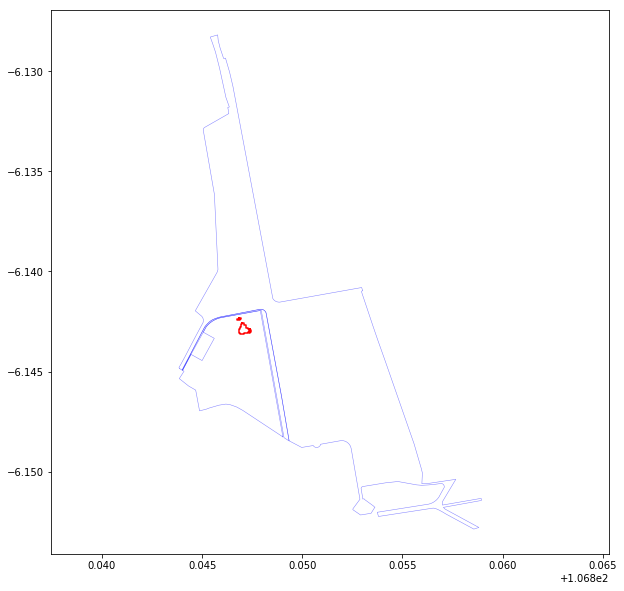

In [59]:
fig = plt.figure(figsize = (10,10))

for percil in gdf_persil.geometry:
    try:
        x,y = [poly.boundary.xy for poly in percil][0]
    except: 
        x,y = [poly.exterior.xy for poly in percil][0]
    plt.plot(x,y, color = 'b', linewidth=0.5, alpha = 0.5)

if isinstance(water_wgs_shp, shapely.geometry.multipolygon.MultiPolygon):
    for water in water_wgs_shp:

        print(water.area)

        try:
            x,y = water.boundary.xy
        except:
            x,y = water.exterior.xy

        plt.plot(x,y, color = 'r')
else: 
    x,y = water_wgs_shp.exterior.xy

    plt.plot(x,y, color = 'r')


plt.axis('equal')


plt.show()

In [195]:
import folium



import pandas as pd

try:
    x,y = result_wgs_shp[0].centroid.xy
except:
    x,y = result_wgs_shp.centroid.xy

m = folium.Map(location=[y[0], x[0]], zoom_start=16, max_zoom = 30)

for poly in polygon_list_wgs_shp[0:500]:
    folium.Choropleth(
        geo_data=poly,
        legend_name='persil data'
    ).add_to(m)
    

for poly in [result_wgs_shp]:
    folium.Choropleth(
        geo_data=poly, 
        name='detected water',
    ).add_to(m)


folium.LayerControl().add_to(m)

m